Next: https://github.com/arunarn2/HierarchicalAttentionNetworks/blob/master/HierarchicalAttn.py

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np

In [4]:
import tensorflow as tf
import tensorflow_hub as hub

In [5]:
from keras import backend as K
from keras.models import Model, Input, load_model
from keras.layers import LSTM, Dense, TimeDistributed, Bidirectional, Lambda
from keras.optimizers import RMSprop, Adam, Adamax, SGD
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from keras.layers.merge import add
from keras.utils import to_categorical

Using TensorFlow backend.


In [3]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score as scikit_f1_score

#### Custom Functions

In [6]:
from src.callbacks import PlotCurves
from src.eval_metrics import f1_macro, f1_micro # Many-to-one does not return a sequential y_preds.
from src.load_data import load_data

### Load Data

In [7]:
train_data, valid_data, test_data, metadata = load_data()

### Prepare data

In [8]:
ww = 2
n_tags = 2
batch_size = 2

In [9]:
def get_input(data_, ww, n_tags, is_test=False, limit=None):
    
    def normalize(text):
        return text.replace('\n', '').strip().lower() 
    
    padding_sent = {
        'sentence': 'ENDPAD',
        'label': 0
    }

    X = []
    y = []

    for article in data_:
        sent_objs = article['sentences']
        
        for si, sentence in enumerate(sent_objs):
            sequence = []

            # Prev
            for i in reversed(range(ww)):
                sequence.append(normalize(sent_objs[si-i-1]['sentence']) 
                                if si-i-1 >= 0 
                                else padding_sent['sentence'])

            # Curr
            sequence.append(normalize(sent_objs[si]['sentence']))

            # Next
            for i in range(ww):
                sequence.append(normalize(sent_objs[si+i+1]['sentence'] )
                                if si+i+1 < len(article['sentences']) 
                                else padding_sent['sentence'])

            X.append(sequence)
            y.append(sent_objs[si]['label']
                     if is_test 
                     else to_categorical(sent_objs[si]['label'], num_classes=n_tags))
    
    if not limit:
        limit = len(X) if len(X)%2 == 0 else len(X)-1

    return np.array(X)[:limit], np.array(y)[:limit]

In [10]:
X_tra, y_tra = get_input(train_data, ww, n_tags, False)
X_val, y_val = get_input(valid_data, ww, n_tags, False)
X_test, y_test = get_input(test_data, ww, n_tags, True)

In [11]:
X_tra.shape, X_val.shape, X_test.shape

((3582, 3), (398, 3), (440, 3))

### Load ELMo

In [12]:
sess = tf.Session()
K.set_session(sess)

In [13]:
elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

## Build Model

In [14]:
def ELMoEmbedding(x):
    embeds = []
    for art in tf.unstack(tf.transpose(x, (1, 0))):
        embeds.append(elmo(tf.squeeze(tf.cast(art, tf.string)), signature="default", as_dict=True)["default"])
    return tf.stack(embeds, 1)

In [15]:
def build_lstm_model(ww, n_tags):
    
    inp_size = 2*ww+1
    
    input_text = Input(shape=(inp_size,), dtype="string")
    
    embedding = Lambda(ELMoEmbedding, output_shape=(None, None, inp_size, 1024))(input_text)
    
    dns = Dense(512, activation='relu')(embedding)
    
    dns = Dense(256, activation='relu')(dns)
    
    x = Bidirectional(LSTM(units=128, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(dns)

    x_rnn = Bidirectional(LSTM(units=128, return_sequences=True,
                               recurrent_dropout=0.2, dropout=0.2))(x)

    x = add([x, x_rnn])

    out = LSTM(units=2)(x)
    
    return Model(input_text, outputs=out)

In [16]:
learningrate=0.001
optimizer = Adam(lr=learningrate)
optimizer_str = 'adam'
loss = 'binary_crossentropy'
metrics = ['acc', f1_macro, f1_micro]

In [18]:
model = build_lstm_model(ww, n_tags)
model.summary()

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, None, None, 3 524800      lambda_2[0][0]                   
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, None, None, 3 131328      dense_3[0][0]                    
__________________________________________________________________________________________________
bidirectio

In [20]:
model_name = 'RQ2_test_elmo_many_to_one_model_0' + \
             '_ww_' + str(ww) + \
             '_' + optimizer_str + \
             '_lr_' + str(learningrate) + \
             '_lrreduction' + \
             '_loss_' + loss

model_dir = './Model/' + model_name.split('model')[0] + 'model/' + model_name
results_file = os.path.join(model_dir, 'model_results_file.txt')

### Train Model

<Figure size 720x360 with 0 Axes>

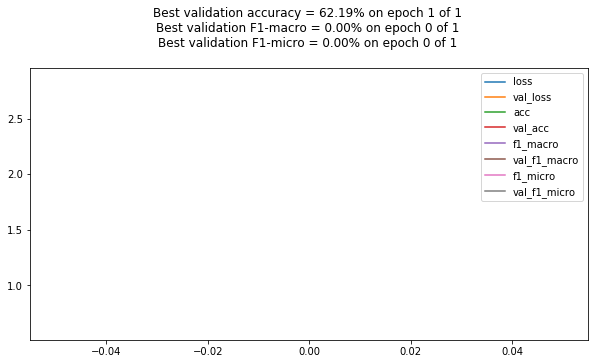

In [21]:
model.fit(X_tra, y_tra, 
          epochs=50, 
          batch_size=batch_size, 
          validation_data=(X_val, y_val), 
          callbacks=[
              PlotCurves(model_name=model_name, model_dir=model_dir, jnote=True),
              ReduceLROnPlateau(monitor='val_f1_macro', patience=3, 
                                factor=0.1, min_lr=0.00001),
              EarlyStopping(monitor='val_f1_macro', min_delta=0, patience=10, mode='max')
          ])

### Load the best Model

In [22]:
model_name

'RQ2_elmo_many_seqqqqqqteeeest_to_one_model_0_ww_1_Adam_lr_0.001_loss_binary_crossentropy'

In [ ]:
best_model = load_model(os.path.join(model_dir, model_name + '_best_f1_macro_model.h5'), 
                        custom_objects={'elmo':elmo, 'tf':tf, 'f1_macro':f1_macro, 'f1_micro':f1_micro})

### Evaluation

In [27]:
def get_scores(model, data_, batch_size, ww, n_tags, results_file):
    
    X, y = get_input(data_, ww, n_tags, True)
    
    y_preds = model.predict(X, batch_size=batch_size)
    y_preds = np.argmax(y_preds, axis=1)
    
    clsrpt = classification_report(y, y_preds)
    sfm = scikit_f1_score(y, y_preds, average='macro')

    print(clsrpt)
    print('\nScikit_F1_Macro:', sfm)

    if results_file:
        with open(results_file, 'a') as f:
            f.write('\n' + clsrpt + '\n' + str(sfm) + '\n\n')

#### Validation Set

In [28]:
with open(results_file, 'w') as f:
    f.write('\n---------------- Validation ----------------\n')

In [ ]:
get_scores(model, valid_data, batch_size, ww, n_tags, results_file)

#### Test Set

In [ ]:
with open(results_file, 'a') as f:
    f.write('\n---------------- Test ----------------\n')

In [ ]:
get_scores(model, test_data, batch_size, ww, n_tags, results_file)